In [ ]:
import matplotlib.pyplot as plt
!apt-get update -qq
!apt-get install fonts-nanum* -qq # matplotlib는 한글 지원이 안돼서 나눔 폰트를 다운 받음
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=f'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe) # ttf를 0번 자리에 fe란 이름으로 넣어줌
# 폰트 사이즈별로 폰트 이미지가 있음 -> family
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

plt.rc('figure', figsize=(10,10))
font_option={ 'family': 'NanumGothic',
             'weight':'bold',
              'size':20}
plt.rc('font', **font_option)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. 데이터 로드 및 정렬
file_path = '/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/Glucose/Table_last2.csv'  # CSV 파일 경로
df = pd.read_csv(file_path)

# DateTime 열을 datetime 형식으로 변환 및 정렬
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# 2. 날짜별 마지막 시간대 데이터 추출
df['Date'] = df['DateTime'].dt.date
last_time_df = df.groupby('Date').last().reset_index()

# 3. 다음날 아침 혈당값 생성 (Shift)
last_time_df['Next_Morning_Glucose'] = last_time_df['Glucose'].shift(-1)
last_time_df.dropna(subset=['Next_Morning_Glucose'], inplace=True)

# 4. 계산용 변수 생성 (last_time_df 기준)
# 상호작용 변수 생성
last_time_df['Meal_Glucose_Interaction'] = last_time_df['meal_status'] * last_time_df['Glucose']
last_time_df['Hypo_Glucose_Interaction'] = last_time_df['hypoglycemia'] * last_time_df['Glucose']
last_time_df['Meal_Exercise_Interaction'] = last_time_df['meal_amount'] * last_time_df['exercise_level']
last_time_df['Exercise_Glucose_Interaction'] = last_time_df['exercise_level'] * last_time_df['Glucose']

# 변화량 계산 (다음 시간대 - 현재 시간대)
last_time_df['Glucose_Change'] = last_time_df['Glucose'].shift(-1) - last_time_df['Glucose']
last_time_df['Meal_Status_Change'] = last_time_df['meal_status'].shift(-1) - last_time_df['meal_status']
last_time_df['Hypoglycemia_Change'] = last_time_df['hypoglycemia'].shift(-1) - last_time_df['hypoglycemia']
last_time_df['Meal_Amount_Change'] = last_time_df['meal_amount'].shift(-1) - last_time_df['meal_amount']
last_time_df['Exercise_Level_Change'] = last_time_df['exercise_level'].shift(-1) - last_time_df['exercise_level']

# 인슐린 투여량 변화량 계산 (다음 시간대 - 현재 시간대)
last_time_df['Regular_Insulin_Change'] = last_time_df['Regular_Insulin'].shift(-1) - last_time_df['Regular_Insulin']
last_time_df['NPH_Insulin_Change'] = last_time_df['NPH_Insulin'].shift(-1) - last_time_df['NPH_Insulin']
last_time_df['UltraLente_Insulin_Change'] = last_time_df['UltraLente_Insulin'].shift(-1) - last_time_df['UltraLente_Insulin']


# 결측값 제거 (변화량 계산 후)
last_time_df.dropna(inplace=True)

# 5. 독립변수(X)와 종속변수(y) 설정
X = last_time_df[['Regular_Insulin', 'NPH_Insulin', 'UltraLente_Insulin',  # 인슐린 종류별 투여량 포함
                  'Meal_Glucose_Interaction',
                  'Hypo_Glucose_Interaction',
                  'Meal_Exercise_Interaction',
                  'Exercise_Glucose_Interaction',
                  'Glucose_Change',
                  'Meal_Status_Change',
                  'Hypoglycemia_Change',
                  'Meal_Amount_Change',
                  'Exercise_Level_Change',
                  'Regular_Insulin_Change',
                  'NPH_Insulin_Change',
                  'UltraLente_Insulin_Change']]
y = last_time_df['Next_Morning_Glucose']

# 6. 데이터 분리 (훈련:검증 = 80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 8. 예측 수행 및 성능 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"랜덤 포레스트 RMSE: {rmse:.2f}")
print(f"랜덤 포레스트 MAE: {mae:.2f}")


# 9. 전체 데이터에 예측값 추가
last_time_df['Predicted_Next_Morning_Glucose'] = model.predict(X)

# 10. 원본 데이터(`Table_last2`)에 예측값 병합 (계산용 변수는 포함하지 않음)
result_df = pd.merge(df[['DateTime', 'Regular_Insulin', 'NPH_Insulin', 'UltraLente_Insulin',
                         'meal_status', 'hypoglycemia', 'meal_amount',
                         'exercise_level', 'Glucose']],
                     last_time_df[['Date', 'Predicted_Next_Morning_Glucose']],
                     how='left', left_on=df['DateTime'].dt.date, right_on='Date')

# 불필요한 열 제거
result_df.drop(columns=['Date'], inplace=True, errors='ignore')

랜덤 포레스트 RMSE: 50.80
랜덤 포레스트 MAE: 40.67


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 7. 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 8. 예측 수행 및 성능 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"랜덤 포레스트 RMSE: {rmse:.2f}")
print(f"랜덤 포레스트 MAE: {mae:.2f}")

랜덤 포레스트 RMSE: 50.80
랜덤 포레스트 MAE: 40.67


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. 종속 변수와 외생 변수 설정
y = last_time_df['Next_Morning_Glucose']  # 종속 변수
exog = last_time_df[['Meal_Glucose_Interaction', 'Hypo_Glucose_Interaction',
                     'Meal_Exercise_Interaction', 'Exercise_Glucose_Interaction',
                     'Glucose_Change', 'Meal_Status_Change', 'Hypoglycemia_Change',
                     'Meal_Amount_Change', 'Exercise_Level_Change',
                     'Regular_Insulin_Change', 'NPH_Insulin_Change', 'UltraLente_Insulin_Change']]  # 계산용 변수

# 2. XARIMAX 모델 학습
model = SARIMAX(y, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# 3. 예측 수행
y_pred = results.predict(start=0, end=len(y)-1, exog=exog)

# 4. 성능 평가
rmse = np.sqrt(mean_squared_error(y.dropna(), y_pred.dropna()))
mae = mean_absolute_error(y.dropna(), y_pred.dropna())

print(f"XARIMAX RMSE: {rmse:.2f}")
print(f"XARIMAX MAE: {mae:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


XARIMAX RMSE: 48.21
XARIMAX MAE: 39.47


In [ ]:
# 예측 수행
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 종속 변수와 외생 변수 설정
endog = last_time_df[['Next_Morning_Glucose', 'Glucose']]  # 다변량 종속 변수
exog = last_time_df[['Meal_Glucose_Interaction', 'Hypo_Glucose_Interaction',
                     'Meal_Exercise_Interaction', 'Exercise_Glucose_Interaction',
                     'Glucose_Change', 'Meal_Status_Change', 'Hypoglycemia_Change',
                     'Meal_Amount_Change', 'Exercise_Level_Change',
                     'Regular_Insulin_Change', 'NPH_Insulin_Change', 'UltraLente_Insulin_Change']]  # 외생 변수

# VARMAX 모델 학습
model = VARMAX(endog=endog, exog=exog, order=(1, 1))  # (p=1, q=1)
results = model.fit(disp=False)

# 예측 수행
y_pred = results.forecast(steps=len(endog), exog=exog)

# y_pred가 Pandas DataFrame이므로 열 이름을 사용해 접근
rmse = np.sqrt(mean_squared_error(endog['Next_Morning_Glucose'], y_pred['Next_Morning_Glucose']))
mae = mean_absolute_error(endog['Next_Morning_Glucose'], y_pred['Next_Morning_Glucose'])

print(f"VARMAX RMSE: {rmse:.2f}")
print(f"VARMAX MAE: {mae:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


VARMAX RMSE: 49.13
VARMAX MAE: 40.69


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 종속 변수와 외생 변수 설정
y = last_time_df['Next_Morning_Glucose']  # 종속 변수
exog = last_time_df[['Meal_Glucose_Interaction', 'Hypo_Glucose_Interaction',
                     'Meal_Exercise_Interaction', 'Exercise_Glucose_Interaction',
                     'Glucose_Change', 'Meal_Status_Change', 'Hypoglycemia_Change',
                     'Meal_Amount_Change', 'Exercise_Level_Change',
                     'Regular_Insulin_Change', 'NPH_Insulin_Change', 'UltraLente_Insulin_Change']]  # 외생 변수

# 최적의 파라미터로 SARIMAX 모델 학습
model = SARIMAX(
    y,
    exog=exog,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# AIC와 BIC 출력
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# 예측 수행 및 성능 평가
y_pred = results.predict(start=0, end=len(y)-1, exog=exog)
rmse = np.sqrt(mean_squared_error(y.dropna(), y_pred.dropna()))
mae = mean_absolute_error(y.dropna(), y_pred.dropna())

print(f"SARIMAX RMSE: {rmse:.2f}")
print(f"SARIMAX MAE: {mae:.2f}")


AIC: 988.66
BIC: 1029.52
XARIMAX RMSE: 41.64
XARIMAX MAE: 33.81


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 데이터 로드
file_path = '/content/drive/MyDrive/05_daejeon_konyang/Table_last2_morning2.csv'  # 파일 경로 지정
df = pd.read_csv(file_path)

# DateTime 열을 datetime 형식으로 변환 및 정렬
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# 'Next_Morning_Glucose'를 타겟 변수로 설정
target_series = df['Predicted_Next_Morning_Glucose']
# ADF Test 함수 정의
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

# 정상성 검사 수행
print("정상성 검사 결과 (Predicted_Next_Morning_Glucose):")
adf_test(target_series)


정상성 검사 결과 (Predicted_Next_Morning_Glucose):
ADF Statistic: -8.081406472748693
p-value: 1.45806489590469e-12
Critical Values:
   1%: -3.432591458200774
   5%: -2.862530326950686
   10%: -2.567297178762432


<ipython-input-15-b308e3c741df>:12: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


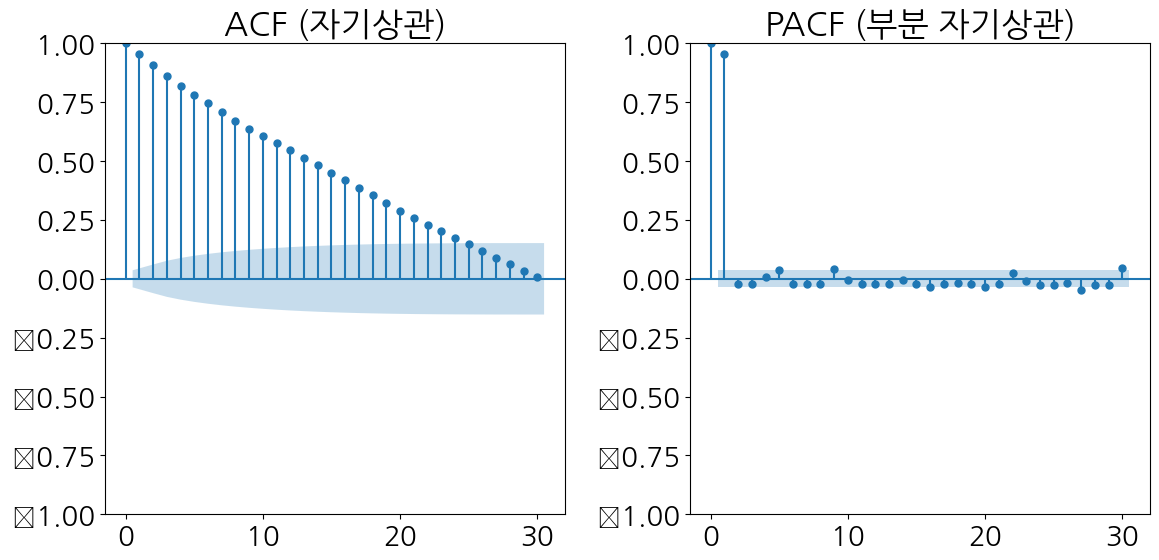

In [ ]:
# ACF와 PACF 플롯 그리기
plt.figure(figsize=(12, 6))

# ACF (자기상관 함수)
plt.subplot(1, 2, 1)
plot_acf(target_series.dropna(), lags=30, ax=plt.gca(), title="ACF (자기상관)")

# PACF (부분 자기상관 함수)
plt.subplot(1, 2, 2)
plot_pacf(target_series.dropna(), lags=30, ax=plt.gca(), title="PACF (부분 자기상관)")

plt.tight_layout()
plt.show()


In [ ]:
# 3. Grid Search로 최적의 (p, d, q) 및 (P, D, Q, m) 탐색
p = d = q = range(0, 3)  # 비계절적 파라미터 범위
seasonal_p = seasonal_d = seasonal_q = range(0, 2)  # 계절적 파라미터 범위
seasonal_periods = [7]  # 주기 (7일 기준)

pdq_combinations = list(itertools.product(p, d, q))
seasonal_pdq_combinations = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, seasonal_periods))

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

for param in pdq_combinations:
    for seasonal_param in seasonal_pdq_combinations:
        try:
            model_sarimax = SARIMAX(
                y,
                exog=exog,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results_sarimax = model_sarimax.fit(disp=False)
            if results_sarimax.aic < best_aic:
                best_aic = results_sarimax.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
        except Exception as e:
            continue

print(f"최적 XARIMAX 모델: Order={best_pdq}, Seasonal_Order={best_seasonal_pdq}, AIC={best_aic:.2f}")

In [ ]:
# 최적의 p,d,q,m 결과: order=(0, 1, 2), seasonal_order=(0, 1, 1, 7)
#Order (p, d, q): (0, 1, 2)
#p: AR(자기회귀) 차수 = 0 데이터에 자기회귀(AR) 성분이 없음을 의미
#d: 차분 횟수 = 1 데이터가 비정상적이므로 한 번 차분하여 정상성을 만족
#q: MA(이동 평균) 차수 = 2 이동 평균(MA) 성분이 강하며, ACF 플롯에서 Lag=2까지 상관 계수가 유의미

# Seasonal Order (P, D, Q, m): (0, 1, 1, 7)
# P: 계절적 AR 차수 = 0 계절적 자기회귀 성분이 없음
# D: 계절적 차분 횟수 = 1 계절성을 제거하기 위해 한 번의 계절적 차분을 수행
# Q: 계절적 MA 차수 = 1 계절적 이동 평균 성분이 존재하며, 과거 한 번의 계절적 오차를 기반으로 현재를 예측함
# m: 계절 주기 = 7 (주간 패턴) 주기가 7로 설정되었으므로 데이터가 주간 패턴(예: 매일 또는 매주 반복되는 패턴)을 따르고 있음을 나타냄

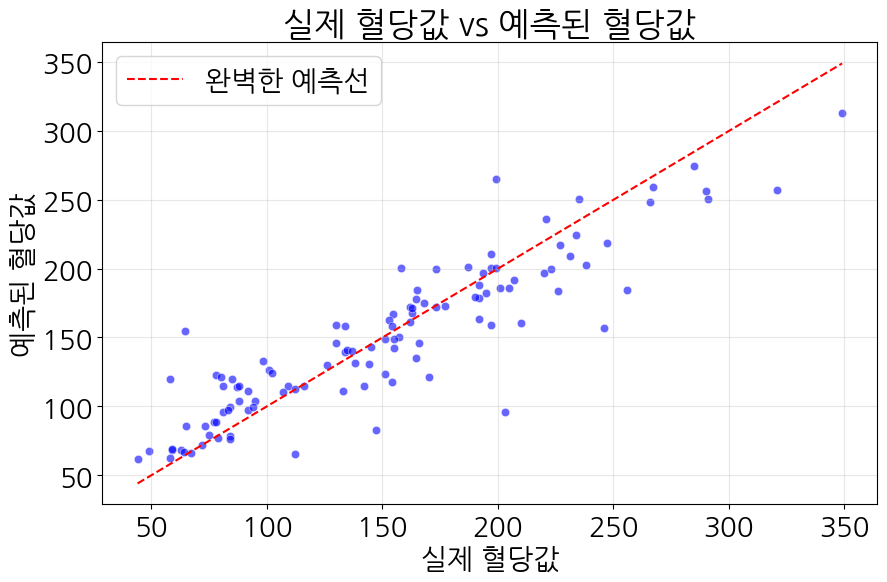

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 산점도 시각화 (실제값 vs 예측값)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=last_time_df["Predicted_Next_Morning_Glucose"], color='blue', alpha=0.6)

# 완벽한 예측선 추가
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='완벽한 예측선')

# 그래프 제목 및 축 레이블 설정
plt.title('실제 혈당값 vs 예측된 혈당값')  # 그래프 제목
plt.xlabel('실제 혈당값')  # x축 제목
plt.ylabel('예측된 혈당값')  # y축 제목

# 범례 및 그리드 추가
plt.legend()
plt.grid(alpha=0.3)

# 그래프 출력
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


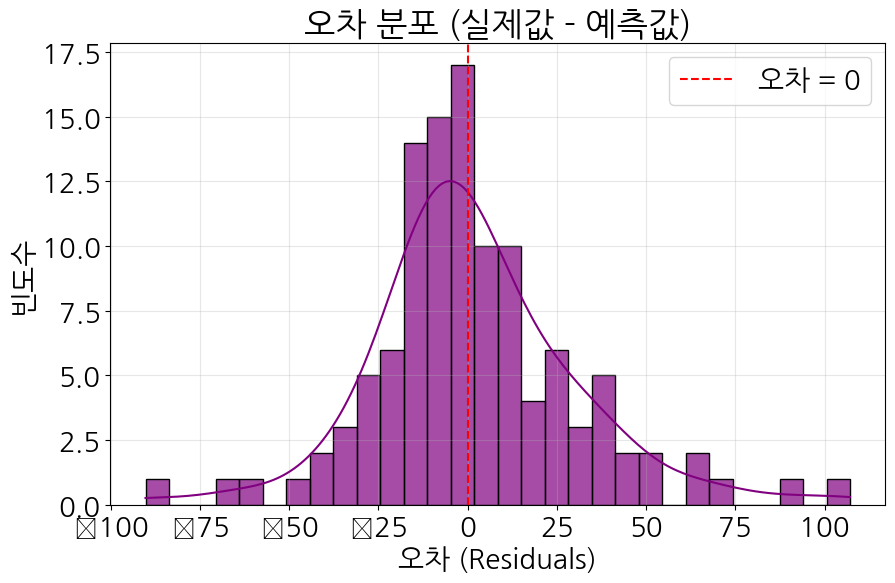

In [ ]:
# 오차 계산
residuals = last_time_df['Next_Morning_Glucose'] - last_time_df['Predicted_Next_Morning_Glucose']

# 히스토그램 시각화 (오차 분포)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple', alpha=0.7)
plt.title('오차 분포 (실제값 - 예측값)')  # 그래프 제목 번역
plt.xlabel('오차 (Residuals)')  # x축 제목 번역
plt.ylabel('빈도수')  # y축 제목 번역
plt.axvline(0, color='red', linestyle='--', label='오차 = 0')  # Zero Error -> 오차 = 0
plt.legend()
plt.grid(alpha=0.3)
plt.show()

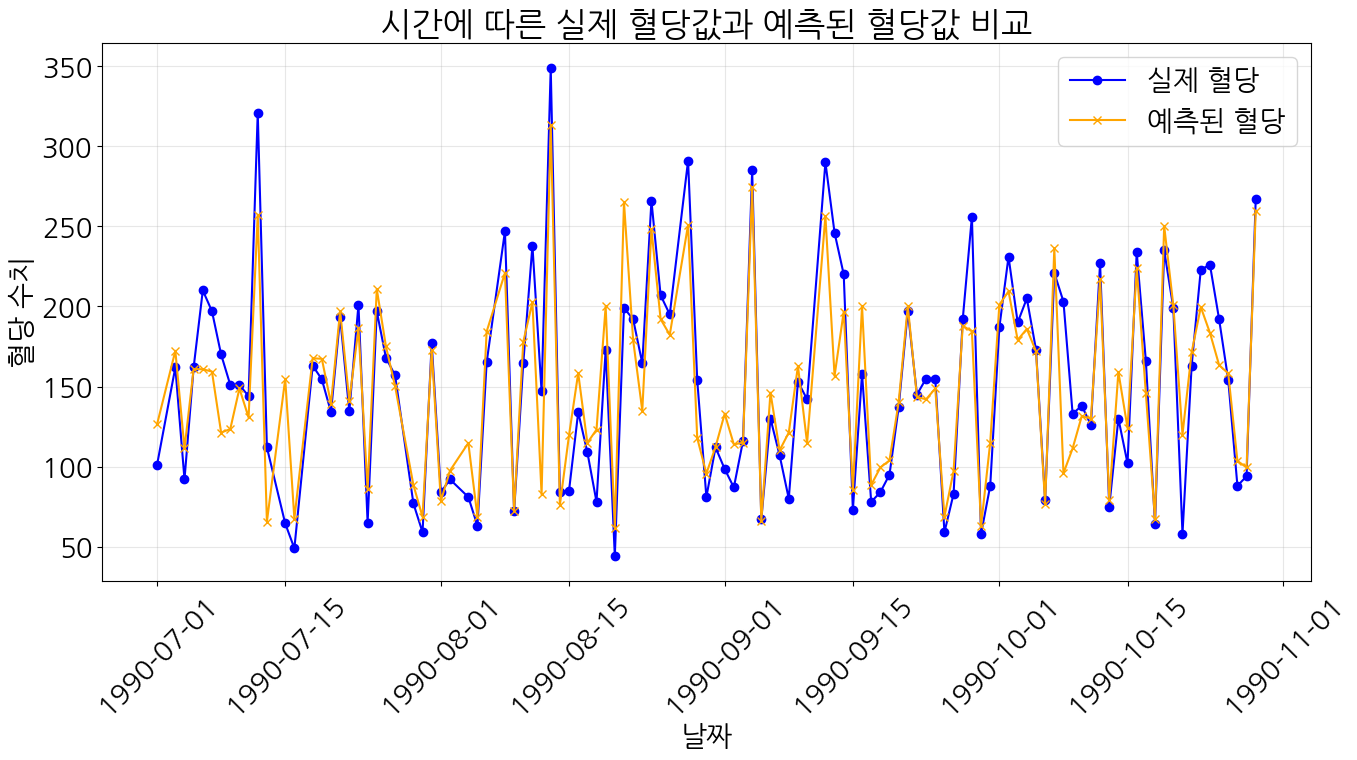

In [ ]:
# 시간 순서대로 정렬
last_time_df_sorted = last_time_df.sort_values('Date')

# 선 그래프 시각화 (시간에 따른 실제값 vs 예측값)
plt.figure(figsize=(14, 8))
plt.plot(last_time_df_sorted['Date'], last_time_df_sorted['Next_Morning_Glucose'], label='실제 혈당', marker='o', color='blue')
plt.plot(last_time_df_sorted['Date'], last_time_df_sorted['Predicted_Next_Morning_Glucose'], label='예측된 혈당', marker='x', color='orange')
plt.title('시간에 따른 실제 혈당값과 예측된 혈당값 비교')  # 그래프 제목 번역
plt.xlabel('날짜')  # x축 제목 번역
plt.ylabel('혈당 수치')  # y축 제목 번역
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
